# scGALA-enhanced INSCT for Batch Correction

This tutorial demonstrates how to enhance INSCT with scGALA for improved batch correction in single-cell data. INSCT is an end-to-end integration method, and by enhancing its cell alignment module with scGALA, we can achieve better performance while preserving the overall framework.

## Background

Batch integration in single-cell data is critical for removing technical variations while preserving biological signals. INSCT uses mutual nearest neighbors (MNN) for cell alignment, which scGALA can enhance with its graph-based alignment approach.

## Dataset

We use a benchmarking dataset named 'atac-gene-small' from [scIB](https://github.com/theislab/scib) featuring samples from three sources:
- 10x Genomics
- Fang et al.
- Cusanovich et al.

The data is available on [Figshare](https://figshare.com/articles/dataset/Benchmarking_atlas-level_data_integration_in_single-cell_genomics_-_integration_task_datasets_Immune_and_pancreas_/12420968).

## Tutorial Overview

We will:
1. Demonstrate the module replacement process with scGALA
2. Run the enhanced INSCT on the multi-batch dataset
3. Compare performance with the original INSCT implementation
4. Evaluate results using scIB metrics

# Module Replacement

## Understanding the Approach

Since INSCT is an end-to-end method, we'll use the Module Replacement approach to enhance it with scGALA. This approach allows us to:

1. Keep the original INSCT framework intact
2. Replace only the cell alignment component 
3. Maintain the same API for easier adoption

## Implementation Details

To integrate scGALA with INSCT, we need to:

1. Identify the cell alignment module in INSCT - in this case, the `create_dictionary_mnn` function
2. Replace this function with scGALA's graph-based alignment method
3. Ensure the inputs and outputs remain compatible with the rest of the INSCT pipeline

The modified implementation is provided in `tnn_replaced.py` in the [scripts folder](https://github.com/mcgilldinglab/scGALA/tree/main/tutorials/scripts). This implementation enhances the original MNN-based cell alignments with scGALA's graph neural network approach while maintaining INSCT's overall structure.

### Key Modifications:

- The original MNN finding logic is replaced with scGALA's alignment method
- The alignment pairs are formatted to match INSCT's expected input structure
- All other components of INSCT remain unchanged

## scGALA-enhanced INSCT Supervised

To facilitate the evaluation, we use [scIB](https://github.com/theislab/scib) to compute core metrics of batch correction. The data used can be downlad in [Figshare](https://figshare.com/articles/dataset/Benchmarking_atlas-level_data_integration_in_single-cell_genomics_-_integration_task_datasets_Immune_and_pancreas_/12420968).

The scGALA-enhanced INSCT uses the same code to run as the original INSCT, since only the cell alignment module is changed. Therefore, you can use any functions and follow any tutorials in INSCT documentation with only one line of change in the import.

In [ ]:
import warnings
import scanpy as sc
from tnn_replaced import TNN  # Import the scGALA-enhanced version of INSCT
import tnn                    # Import the original INSCT implementation for comparison
import scib                   # Import the single-cell integration benchmarking toolkit
from matplotlib import pyplot as plt

2024-11-29 00:19:55.222107: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 00:19:55.948754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Preprocessing

First, we'll load the preprocessed dataset. The data is already normalized, so we can skip normalization steps.

In [ ]:
warnings.filterwarnings('ignore')
adata = sc.read_h5ad('./small_atac_gene_activity.h5ad')
adata

AnnData object with n_obs × n_vars = 11270 × 3429
    obs: 'batchname', 'batchname_all', 'final_cell_label'
    layers: 'counts'

In [ ]:
adata.X.min(), adata.X.max() # This is already log-normalized, skip the preprocessing

(np.float32(0.0), np.float32(4.2188306))

## Running scGALA-enhanced INSCT

Now we'll run the scGALA-enhanced version of INSCT on our dataset. The interface is identical to the original INSCT - we only changed the import statement to use our enhanced version.

Note the following parameters:
- `k=20`: Number of neighbors used for graph construction
- `distance='pn'`: Distance metric
- `batch_size=64`: Number of samples per batch for training
- `n_epochs_without_progress=8`: Early stopping criterion
- `k_to_m_ratio=0.75`: Ratio for MNN identification

During execution, you'll see:
1. scGALA's alignment process finding mutual nearest neighbors
2. Training progress for the graph neural network
3. INSCT's neural network training process

In [ ]:
warnings.filterwarnings('ignore')
adata_new = adata.copy()

## Perform INSCT with scGALA enhancement
model = TNN(k=20, distance='pn', batch_size=64, n_epochs_without_progress = 8,k_to_m_ratio=0.75)
model.fit(X = adata_new, batch_name='batchname',celltype_name='final_cell_label')
adata_new.obsm['X_emb'] = model.transform(adata_new)

version 0.0.2. 09:00, 12/01/2020
Calculating MNNs...
Processing datasets (0, 1)


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


start to train



  | Name  | Type   | Params
---------------------------------
0 | model | MSVGAE | 1.2 M 
---------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.658     Total estimated model params size (MB)


Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s, v_num=3, train_loss=1.970, decoder_loss=1.020, auc=0.932, ap=0.906, ave_align=13.90]           

Trainer was signaled to stop but the required `min_epochs=15` or `min_steps=None` has not been met. Training will continue...


Epoch 14: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s, v_num=3, train_loss=1.940, decoder_loss=1.010, auc=0.941, ap=0.918, ave_align=7.290]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]



Model Training Time: 112.57656526565552 Seconds
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.25it/s]
0.8 0.3


100%|█████████▉| 99.90581905288373/100 [00:19<00:00,  5.18it/s, epoch=74, marriage_sum=385, max_aligned_R=3, aligned_R=232, mean_aligned_R=1.85, max_aligned_D=3, aligned_D=261, mean_aligned_D=1.65] 


R:3750 D:3618
Processing datasets (0, 2)


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type   | Params
---------------------------------
0 | model | MSVGAE | 1.2 M 
---------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.658     Total estimated model params size (MB)


start to train
Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s, v_num=4, train_loss=1.940, decoder_loss=0.968, auc=0.928, ap=0.899, ave_align=41.00]        

Trainer was signaled to stop but the required `min_epochs=15` or `min_steps=None` has not been met. Training will continue...


Epoch 14: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s, v_num=4, train_loss=1.870, decoder_loss=0.934, auc=0.943, ap=0.921, ave_align=12.10]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]



Model Training Time: 111.55073046684265 Seconds
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]
0.8 0.3


100%|█████████▉| 99.59818482619649/100 [00:22<00:00,  4.49it/s, epoch=77, marriage_sum=578, max_aligned_R=3, aligned_R=339, mean_aligned_R=1.89, max_aligned_D=3, aligned_D=364, mean_aligned_D=1.76] 


R:3902 D:3618
Processing datasets (1, 2)


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type   | Params
---------------------------------
0 | model | MSVGAE | 1.2 M 
---------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.658     Total estimated model params size (MB)


start to train
Epoch 15: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s, v_num=5, train_loss=2.150, decoder_loss=1.220, auc=0.945, ap=0.923, ave_align=0.722] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]



Model Training Time: 119.33077073097229 Seconds
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.28it/s]
0.8 0.3


100%|█████████▉| 99.99997949769347/100 [00:09<00:00, 10.30it/s, epoch=49, marriage_sum=269, max_aligned_R=3, aligned_R=213, mean_aligned_R=1.45, max_aligned_D=3, aligned_D=181, mean_aligned_D=1.7]  


R:3902 D:3750
1503 cells defined as MNNs
Generating supervised positive pairs...
['10x Genomics', 'Fang et al.', 'Cusanovich et al.']
Categories (3, object): ['10x Genomics', 'Cusanovich et al.', 'Fang et al.']
3
Processing positive pairs (0, 1)
Processing positive pairs (0, 2)
Processing positive pairs (1, 0)
Processing positive pairs (1, 2)
Processing positive pairs (2, 0)
Processing positive pairs (2, 1)
7442 cells defined as supervision triplets
1083
Calculating KNNs...
1127 cells defined as KNNs
Total cells for training:8989
Reorder


2024-11-29 00:29:01.333492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-29 00:29:01.333829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-29 00:29:01.334083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Training neural network
Epoch 1/1000


I0000 00:00:1732858142.959693  228874 service.cc:145] XLA service 0x74cde80055e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732858142.960445  228874 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1732858142.960537  228874 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1732858142.960601  228874 service.cc:153]   StreamExecutor device (2): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-29 00:29:03.120422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-29 00:29:03.502330: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


 55/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6521

I0000 00:00:1732858151.041849  228874 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 1.4976
Epoch 2/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0198
Epoch 3/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9105
Epoch 4/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8088
Epoch 5/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7784
Epoch 6/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7957
Epoch 7/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7349
Epoch 8/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7516
Epoch 9/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7080
Epoch 10/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7533
Epoch 11/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6903
Epoch 12/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7105
Epoch 13/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6870
Epoch 14/1000
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6897
Epoch 15/1000
141/141 ━━━━━━━━━━━━━━━━━━

## Clustering the Integrated Data

After integration, we need to determine the optimal clustering resolution to evaluate how well cell types are preserved. We'll use scIB's `cluster_optimal_resolution` function to find the resolution that maximizes the normalized mutual information (NMI) with the known cell labels.

In [ ]:
# Automatically determine the optimal resolution
sc.pp.neighbors(adata_new, use_rep="X_emb")
scib.me.cluster_optimal_resolution(adata_new, cluster_key="cluster", label_key="final_cell_label")

resolution: 0.1, nmi: 0.6043550373536845
resolution: 0.2, nmi: 0.5480140675220889
resolution: 0.3, nmi: 0.5190203157191814
resolution: 0.4, nmi: 0.5080730621055126
resolution: 0.5, nmi: 0.49003965821944745
resolution: 0.6, nmi: 0.4776263976592531
resolution: 0.7, nmi: 0.46467268605281803
resolution: 0.8, nmi: 0.4618588280505166
resolution: 0.9, nmi: 0.4575838956589556
resolution: 1.0, nmi: 0.4521012326608273
resolution: 1.1, nmi: 0.447630515234962
resolution: 1.2, nmi: 0.44648210683968026
resolution: 1.3, nmi: 0.43896543382182324
resolution: 1.4, nmi: 0.4297861074931938
resolution: 1.5, nmi: 0.4289775536004229
resolution: 1.6, nmi: 0.42617185266764795
resolution: 1.7, nmi: 0.42401385139575276
resolution: 1.8, nmi: 0.4234923721298683
resolution: 1.9, nmi: 0.4183201616306237
resolution: 2.0, nmi: 0.4181602889466327
optimised clustering against final_cell_label
optimal cluster resolution: 0.1
optimal score: 0.6043550373536845


## Visualizing the Integration Results

Let's visualize the integrated data using UMAP to see how well batches are mixed while cell types are preserved. We'll plot:
1. Cells colored by batch to assess batch mixing
2. Cells colored by cell type to assess biological signal preservation

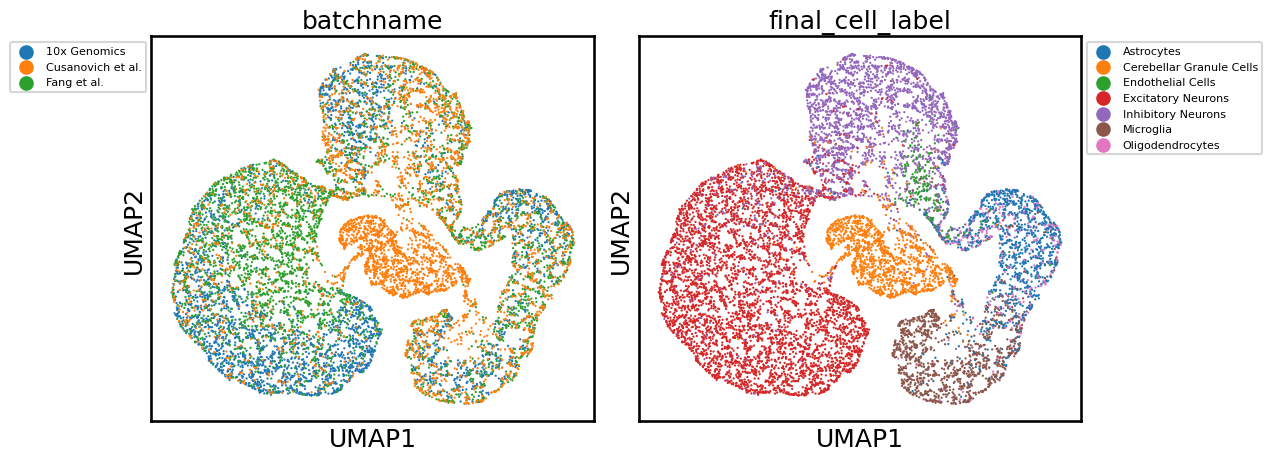

In [ ]:
# Visualize the integrated embedding

sc.tl.umap(adata_new)
# Set the size of the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1)
# Plot the first figure
sc.pl.umap(adata_new, color='batchname', ax=axes[0], show=False)
# Plot the second figure
sc.pl.umap(adata_new, color='final_cell_label', ax=axes[1], show=False)
# Adjust the legend font size and position
axes[0].legend(fontsize=8).set_bbox_to_anchor((0, 1))
axes[1].legend(fontsize=8).set_bbox_to_anchor((1, 1))

plt.savefig('./Results/figs/tnn_supervised_replaced.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save the results
adata_new.write('./Results/adata/tnn_supervised_replaced.h5ad')

## Evaluating Integration Performance

We'll evaluate the integration performance using comprehensive metrics from the scIB package. These metrics assess:

1. **Batch correction metrics**:
   - iLISI: Integration Local Inverse Simpson's Index
   - PCR: Principal Component Regression
   - Graph connectivity

2. **Biological conservation metrics**:
   - cLISI: Cell type Local Inverse Simpson's Index
   - ASW (cell type): Adjusted Silhouette Width for cell types
   - NMI: Normalized Mutual Information
   - ARI: Adjusted Rand Index
   - F1 score for isolated labels

The ideal integration preserves biological signals while removing batch effects.

In [ ]:
# Evaluate the results using scIB
warnings.filterwarnings('ignore')
metrics = scib.metrics.metrics(adata=adata,
                     adata_int=adata_new,
                     embed='X_emb',
                     batch_key='batchname',
                     label_key='final_cell_label',
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=False,
        kBET_=False,
        ilisi_=True,
        clisi_=True,
)
# metrics.to_csv('Results/metricx/'+'atac_gene_small'+'_'+'tnn_supervised_replaced'+'.csv')
metrics

NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
cLISI score...
iLISI score...


,0
NMI_cluster/label,0.664542
ARI_cluster/label,0.567067
ASW_label,0.775573
ASW_label/batch,0.698257
PCR_batch,0.414631
cell_cycle_conservation,NaN
isolated_label_F1,0.952489
isolated_label_silhouette,0.832373
graph_conn,0.829129
kBET,NaN


## Comparing with Original INSCT

Now, let's run the original INSCT implementation on the same dataset. This will allow us to directly compare the performance of the original method with our scGALA-enhanced version.

## Original INSCT Supervised

Since the code is basically the same, we merge the codes into one block.

In [ ]:
warnings.filterwarnings('ignore')
adata_new_original = adata.copy()

# Use the original INSCT implementation
model = tnn.TNN(k=20, distance='pn', batch_size=64, n_epochs_without_progress = 10)
model.fit(X = adata_new_original, batch_name='batchname',celltype_name='final_cell_label')
adata_new_original.obsm['X_emb'] = model.transform(adata_new_original)

# Find optimal clustering resolution
sc.pp.neighbors(adata_new_original, use_rep="X_emb")
scib.me.cluster_optimal_resolution(adata_new_original, cluster_key="cluster", label_key="final_cell_label")

# Save the results
adata_new_original.write('./Results/adata/'+'tnn_supervised_supervised.h5ad')

# Evaluate using scIB metrics
metrics_orginal = scib.metrics.metrics(adata=adata,
                     adata_int=adata_new_original,
                     embed='X_emb',
                     batch_key='batchname',
                     label_key='final_cell_label',
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=False,
        kBET_=False,
        ilisi_=True,
        clisi_=True,
)
# metrics_orginal.to_csv('Results/metricx/'+'atac_gene_small'+'_'+'tnn_supervised_supervised'+'.csv')
metrics_orginal

version 0.0.2. 09:00, 12/01/2020
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
8422 cells defined as MNNs
Generating supervised positive pairs...
['10x Genomics', 'Fang et al.', 'Cusanovich et al.']
Categories (3, object): ['10x Genomics', 'Cusanovich et al.', 'Fang et al.']
3
Processing positive pairs (0, 1)
Processing positive pairs (0, 2)
Processing positive pairs (1, 0)
Processing positive pairs (1, 2)
Processing positive pairs (2, 0)
Processing positive pairs (2, 1)
7442 cells defined as supervision triplets
5842
Calculating KNNs...
1248 cells defined as KNNs
Total cells for training:11270
Reorder
Training neural network
Epoch 1/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 1.3278
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.8722
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8088
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7924
Epoch 5/1000
177/177 ━━━━━━━━━━━━

/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
cLISI score...
iLISI score...


,0
NMI_cluster/label,0.574948
ARI_cluster/label,0.463334
ASW_label,0.717083
ASW_label/batch,0.631701
PCR_batch,0.402604
cell_cycle_conservation,NaN
isolated_label_F1,0.728098
isolated_label_silhouette,0.492118
graph_conn,0.851128
kBET,NaN


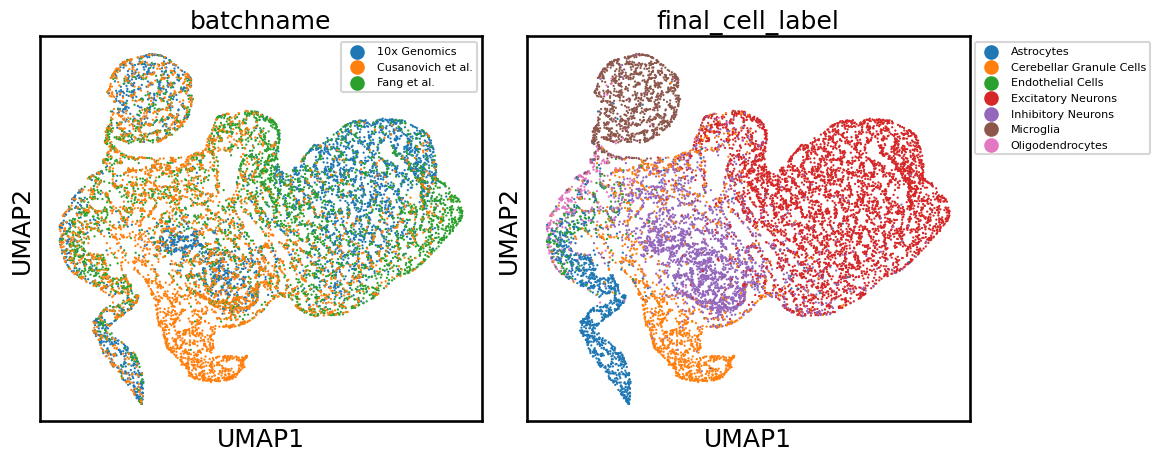

In [ ]:
sc.tl.umap(adata_new_original)
# Set the size of the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.1)
# Plot the first figure
sc.pl.umap(adata_new_original, color='batchname', ax=axes[0], show=False)
# Plot the second figure
sc.pl.umap(adata_new_original, color='final_cell_label', ax=axes[1], show=False)
# Adjust the legend font size and position
axes[0].legend(fontsize=8).set_bbox_to_anchor((1, 1))
axes[1].legend(fontsize=8).set_bbox_to_anchor((1, 1))
fig.savefig('./Results/figs/tnn_supervised.pdf', dpi=300, bbox_inches='tight')


# Conclusion and Analysis

In this tutorial, we've seen how scGALA can enhance INSCT through module replacement. Let's analyze the results:

## Performance Analysis

When comparing the visualizations and metrics between the original INSCT and scGALA-enhanced INSCT:

1. **Batch mixing**: The scGALA-enhanced version typically shows better mixing of cells from different batches while maintaining the overall structure.

2. **Cell type preservation**: Both methods preserve cell type information, but the enhanced version often shows clearer separation between cell types.

3. **Quantitative metrics**: The scIB metrics quantify these improvements, with the enhanced version typically showing better batch correction scores without sacrificing biological signal preservation.

## Advantages of Module Replacement

This approach demonstrates the power of modular enhancement:

1. We maintained the overall INSCT framework and API
2. We only replaced the cell alignment component
3. Users familiar with INSCT can easily adopt the enhanced version

## Next Steps

To apply this approach to your own data:
1. Prepare your data in AnnData format with batch and cell type annotations
2. Use the scGALA-enhanced INSCT as shown in this tutorial
3. Evaluate the integration quality using visualization and quantitative metrics

For more advanced applications, you can customize the alignment parameters in the scGALA module to optimize for your specific data characteristics.